# **FINAL GROUP PROJECT - INSY 695 - Enterprise Data Science**

# **Mobile Phone Price Prediction**

**USE CASE:** The aim of this project is to build a model to predict customer churn (that is, to predict which customers will cancel their subscriptions)

# FRAMING THE PROBLEM

More details about framing the problem....

## SETUP WORKBOOK

**IMPORT PACKAGES**

In [343]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

#!pip install pyjanitor

import janitor as jn
from sklearn import (
    metrics,
    ensemble,
    model_selection,
    preprocessing,
    tree
)
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    cohen_kappa_score,
    confusion_matrix,
    plot_confusion_matrix,
    classification_report
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)
from yellowbrick.model_selection import (
    LearningCurve 
)

**IMPORT DATA**

Source: Kaggle

Link: https://www.kaggle.com/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction


In [223]:
url = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Churn-Analysis/main/data/E%20Commerce%20Dataset.csv"
df = pd.read_csv(url)

In [224]:
url2 = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Churn-Analysis/main/data/Data%20Dictionary.csv"
data_dict = pd.read_csv(url2)

**DATA DICTIONARY**

In [225]:
data_dict.head(10)
data_dict = data_dict.drop('Data', axis=1)
data_dict.style.set_properties(subset=['Discerption'], **{'width': '400px'})

,Variable,Discerption
0,CustomerID,Unique customer ID
1,Churn,Churn Flag
2,Tenure,Tenure of customer in organization
3,PreferredLoginDevice,Preferred login device of customer
4,CityTier,City tier
5,WarehouseToHome,Distance in between warehouse to home of customer
6,PreferredPaymentMode,Preferred payment method of customer
7,Gender,Gender of customer
8,HourSpendOnApp,Number of hours spend on mobile application or website
9,NumberOfDeviceRegistered,Total number of deceives is registered on particular customer


In [226]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


# 1 - EXPLORATORY DATA ANALYSIS

## Data Exploration

In [227]:
df.shape

(5630, 20)

### Check datatypes

In [228]:
df.dtypes

CustomerID                       int64
Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                   int64
dtype: object

Text(0, 0.5, 'Data type')

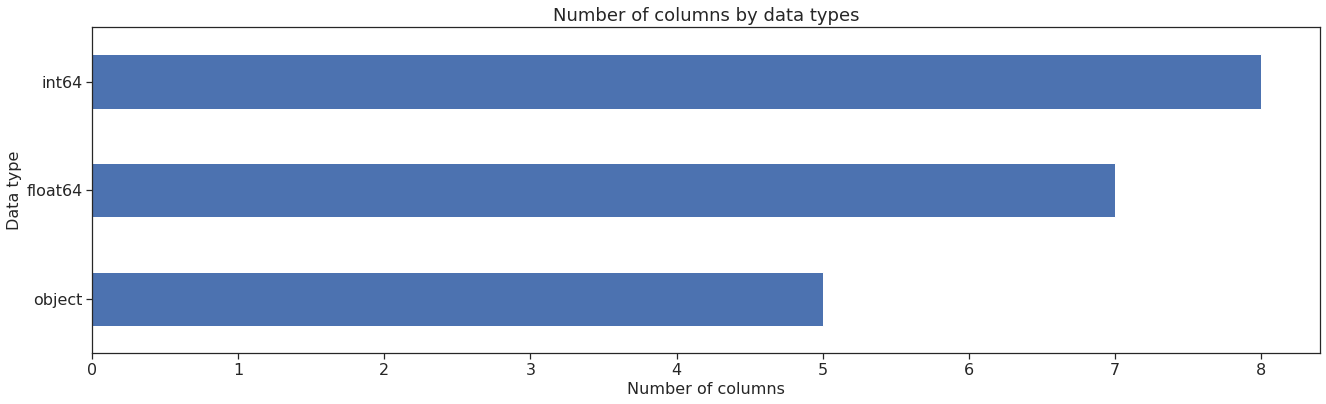

In [229]:
# Number of each type of column
df.dtypes.value_counts().sort_values().plot(kind='barh',
                                            figsize=(22, 6),
                                            fontsize=16)

plt.title('Number of columns by data types', fontsize=18)
plt.xlabel('Number of columns', fontsize=16)
plt.ylabel('Data type', fontsize=16)

Numerical Data:

Categorical Data:

### Check the column names

In [230]:
df.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

### Summary Statistics

In [231]:
df.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.221492
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.193869
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,146.000000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.000000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.000000
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,325.000000


### Pandas Profiling

In [ ]:
#!pip install -U pandas-profiling

#Generate a HTML report
profile = df.profile_report(title='Pandas Profiling Report')
#profile

profile.to_file(output_file="profile_report_output.html")

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Notes from pandas profiling report:
- 

### Check for missing values

In [232]:
def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
    print("Dataframe has " + str(df.shape[1]) + " columns.")
    print("There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    
    return mis_val_table_ren_columns

# Missing values statistics
miss_values = missing_values(df)
miss_values.head(20)

Dataframe has 20 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
DaySinceLastOrder,307,5.5
OrderAmountHikeFromlastYear,265,4.7
Tenure,264,4.7
OrderCount,258,4.6
CouponUsed,256,4.5
HourSpendOnApp,255,4.5
WarehouseToHome,251,4.5


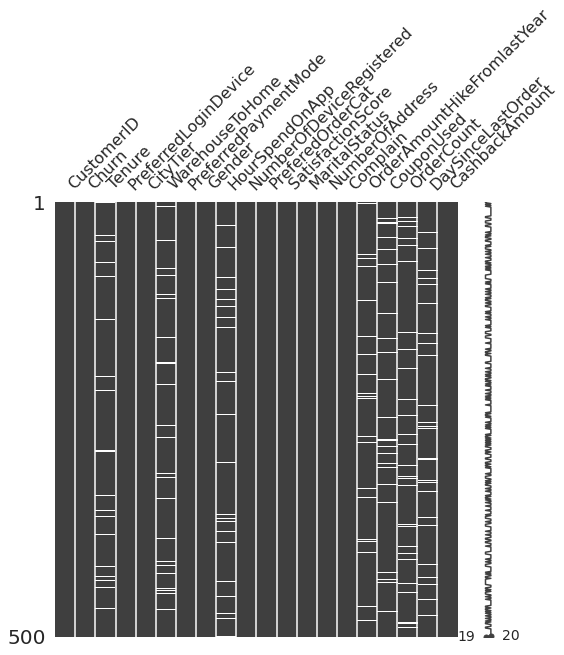

In [233]:
import missingno as msno
msno.matrix(df.sample(500), figsize=(8, 8))
#msno.heatmap(df, figsize=(8, 8))


### Target Variable

In [234]:
df['Churn'].unique()

array([1, 0])

### Correlations

In [235]:
corr = df.corr()['Churn'].sort_values()

# Display correlations
print('8 Positive Correlations:')
print('-----------------------------------')
print(corr.tail(8))
print('\n7 Negative Correlations:')
print('------------------------------')
print(corr.head(7))

8 Positive Correlations:
-----------------------------------
HourSpendOnApp              0.018675
NumberOfAddress             0.043931
WarehouseToHome             0.076630
CityTier                    0.084703
SatisfactionScore           0.105481
NumberOfDeviceRegistered    0.107939
Complain                    0.250188
Churn                       1.000000
Name: Churn, dtype: float64

7 Negative Correlations:
------------------------------
Tenure                        -0.349408
DaySinceLastOrder             -0.160757
CashbackAmount                -0.154161
OrderCount                    -0.028697
CustomerID                    -0.019083
OrderAmountHikeFromlastYear   -0.010058
CouponUsed                    -0.008264
Name: Churn, dtype: float64


In [236]:
corr

Tenure                        -0.349408
DaySinceLastOrder             -0.160757
CashbackAmount                -0.154161
OrderCount                    -0.028697
CustomerID                    -0.019083
OrderAmountHikeFromlastYear   -0.010058
CouponUsed                    -0.008264
HourSpendOnApp                 0.018675
NumberOfAddress                0.043931
WarehouseToHome                0.076630
CityTier                       0.084703
SatisfactionScore              0.105481
NumberOfDeviceRegistered       0.107939
Complain                       0.250188
Churn                          1.000000
Name: Churn, dtype: float64

We can see that no predictors are highly correlated with the target

## Data Visualization

Types of graphs to create:
- 

### Check the distribution of 'Churn'

Drop 'CustomerID'

In [237]:
df = df.drop(['CustomerID'], axis=1)

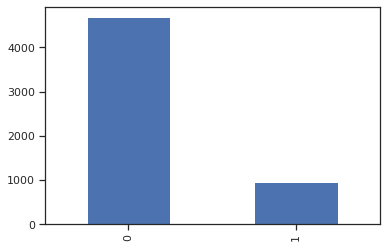

In [238]:
df['Churn'].value_counts().plot(kind='bar')

**NOTE: We see signs of imbalanced data**

### Pair plots across Churn

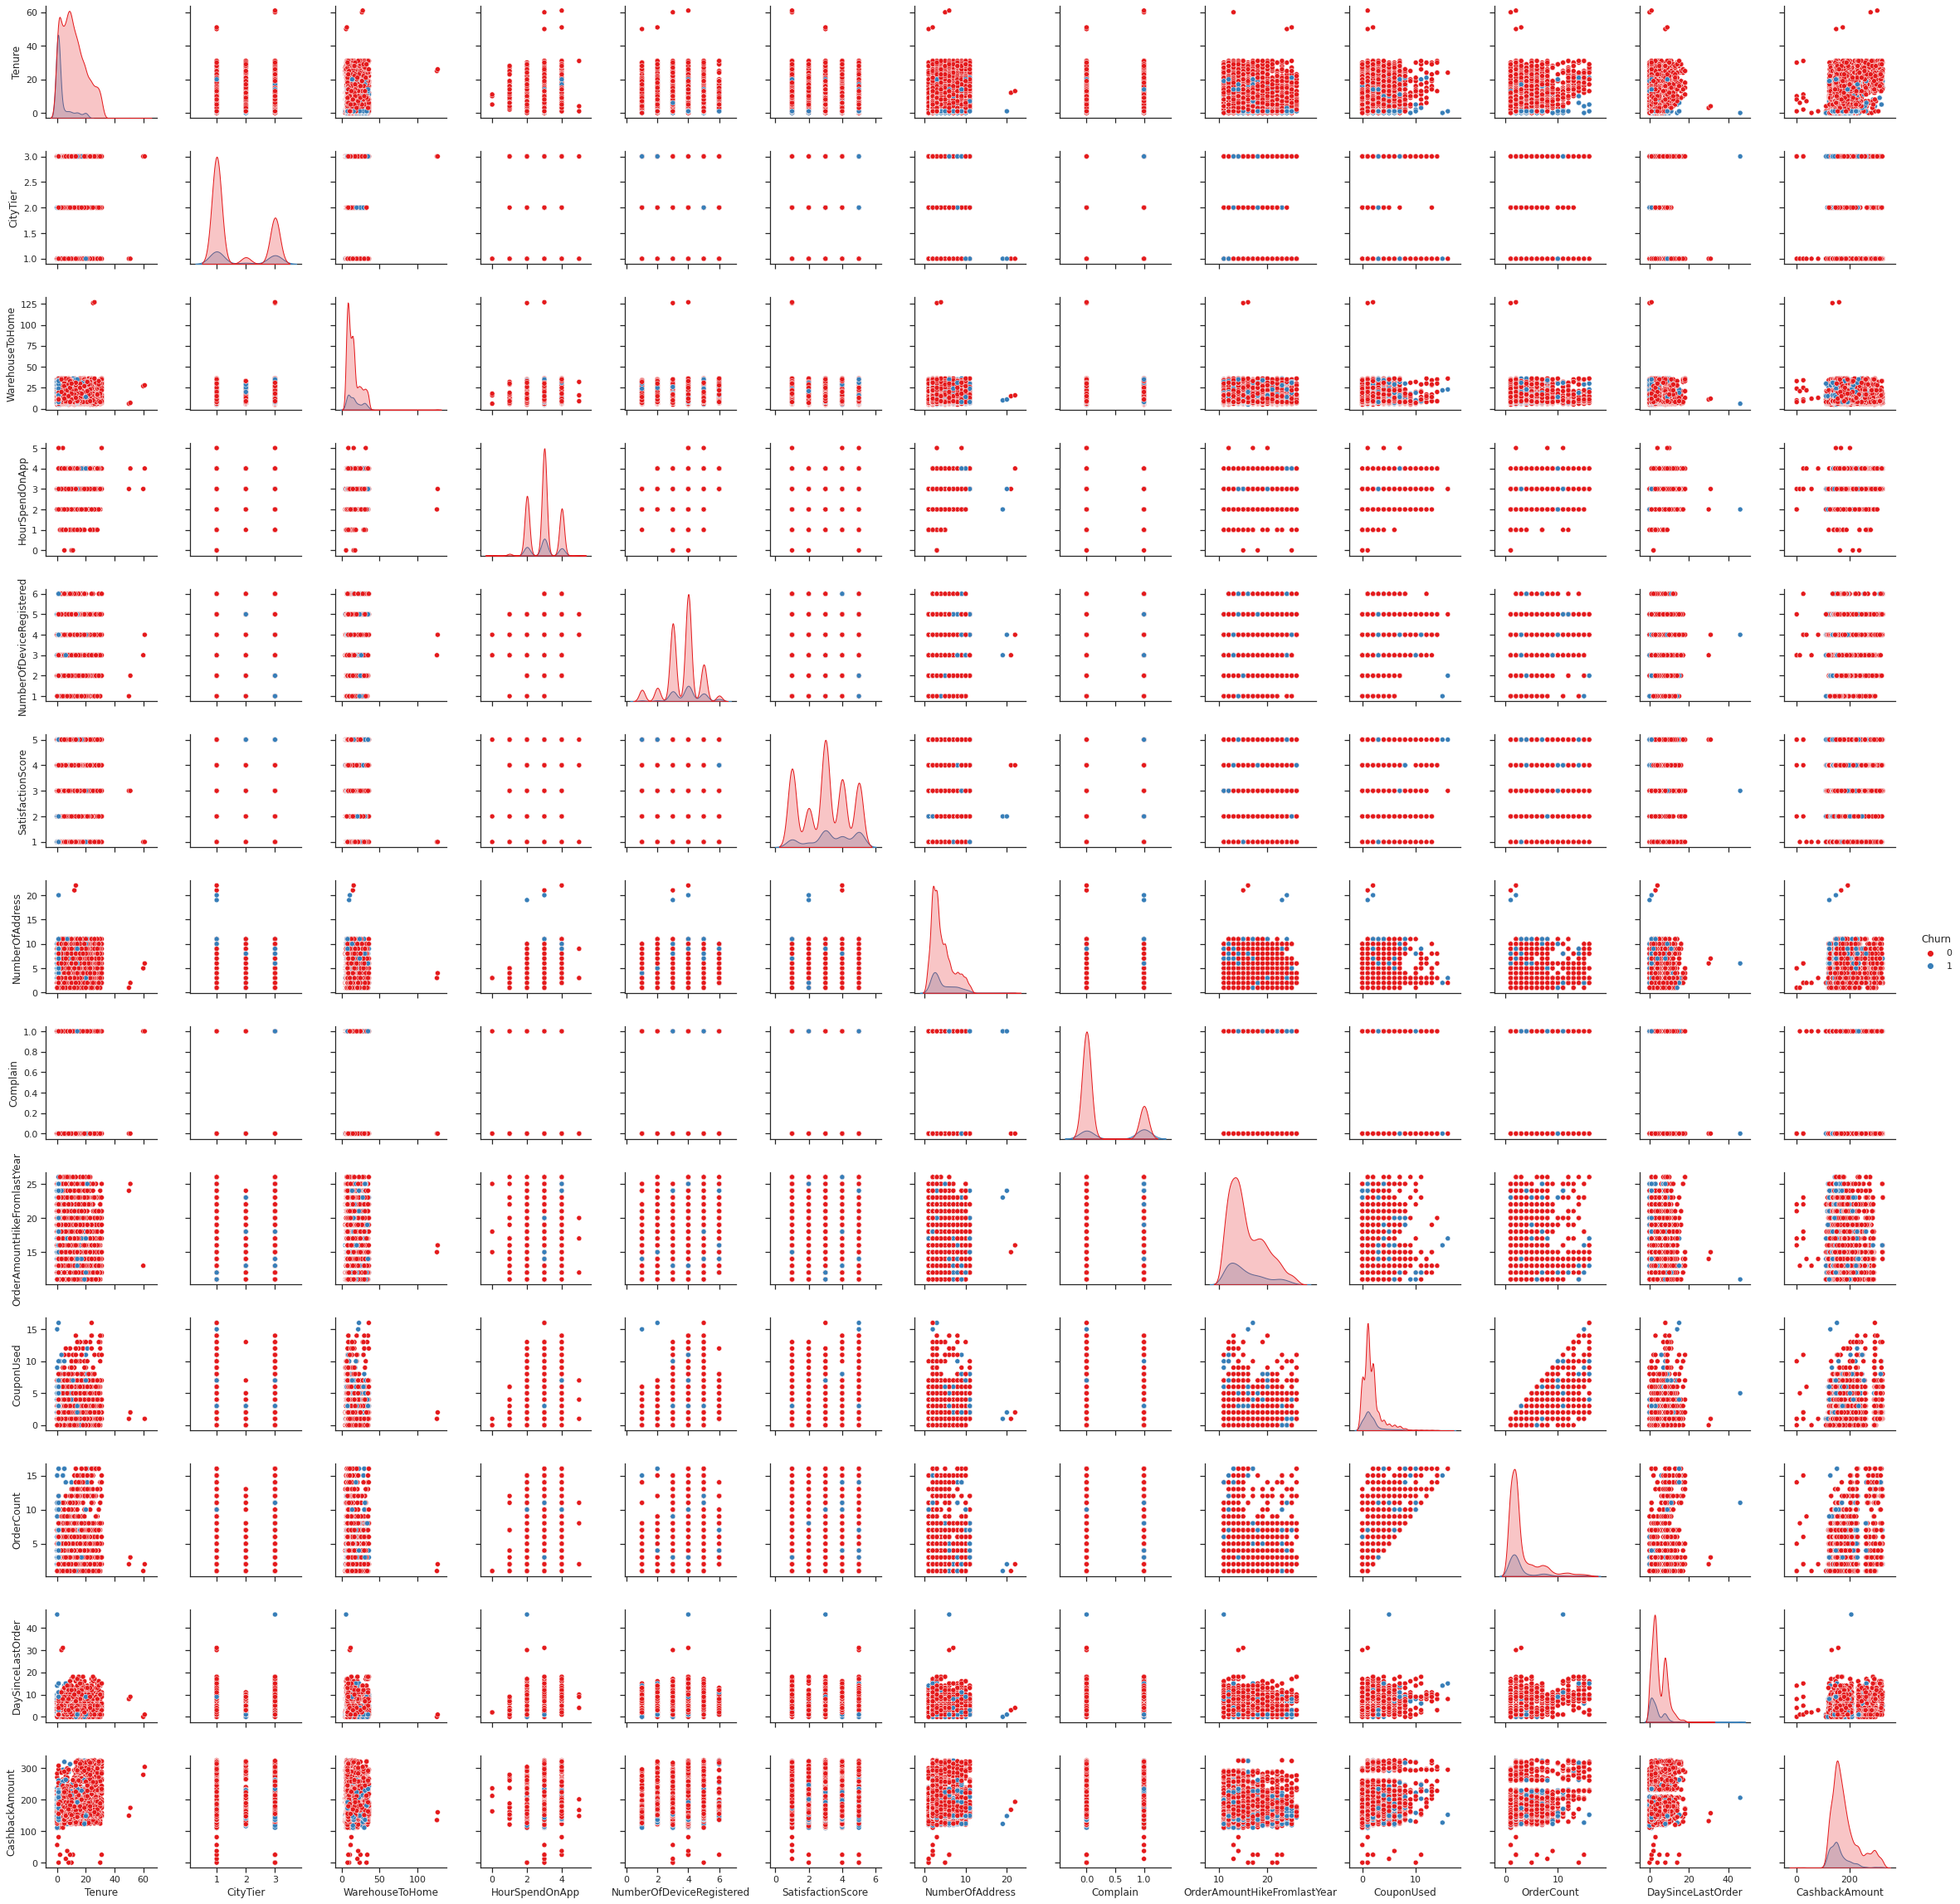

In [19]:
sns.set(style="ticks")

sns.pairplot(df, hue="Churn", palette="Set1")
plt.show()


###Specify which variables you want to see

#new_df = df.copy()
#vars = ["Variable 1", "Variable 2", "Variable 3"]
#p = pairplot(
#    new_df, vars=vars, hue="Churn", kind="reg"
#)

### Distribution of numerical variables

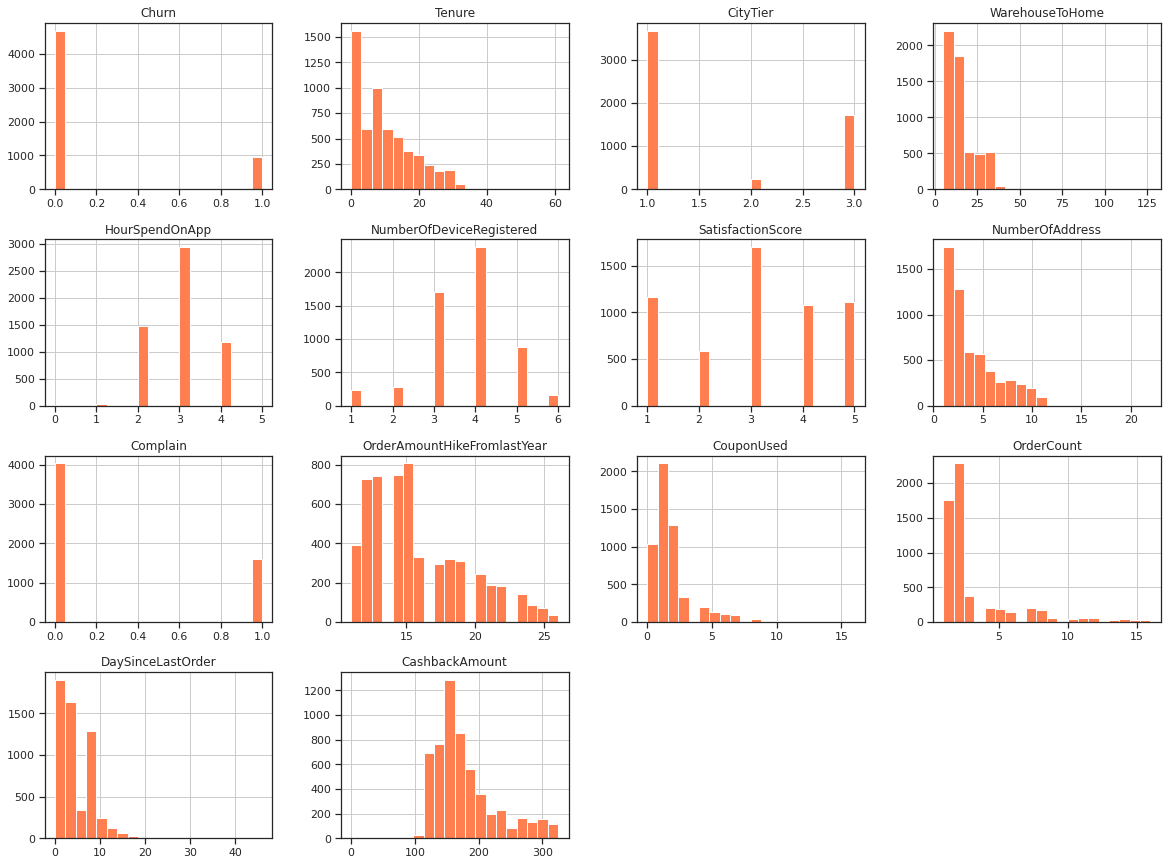

In [63]:
df.hist(bins=20, figsize=(20,15), color='coral')
plt.show();

### Distribution of Categorical Variables

Number of categories in each categorical variable

In [239]:
df.select_dtypes('object').apply(pd.Series.nunique, axis=0)

PreferredLoginDevice    3
PreferredPaymentMode    7
Gender                  2
PreferedOrderCat        6
MaritalStatus           3
dtype: int64

In [240]:
df['PreferredPaymentMode'].value_counts()

Debit Card          2314
Credit Card         1501
E wallet             614
UPI                  414
COD                  365
CC                   273
Cash on Delivery     149
Name: PreferredPaymentMode, dtype: int64

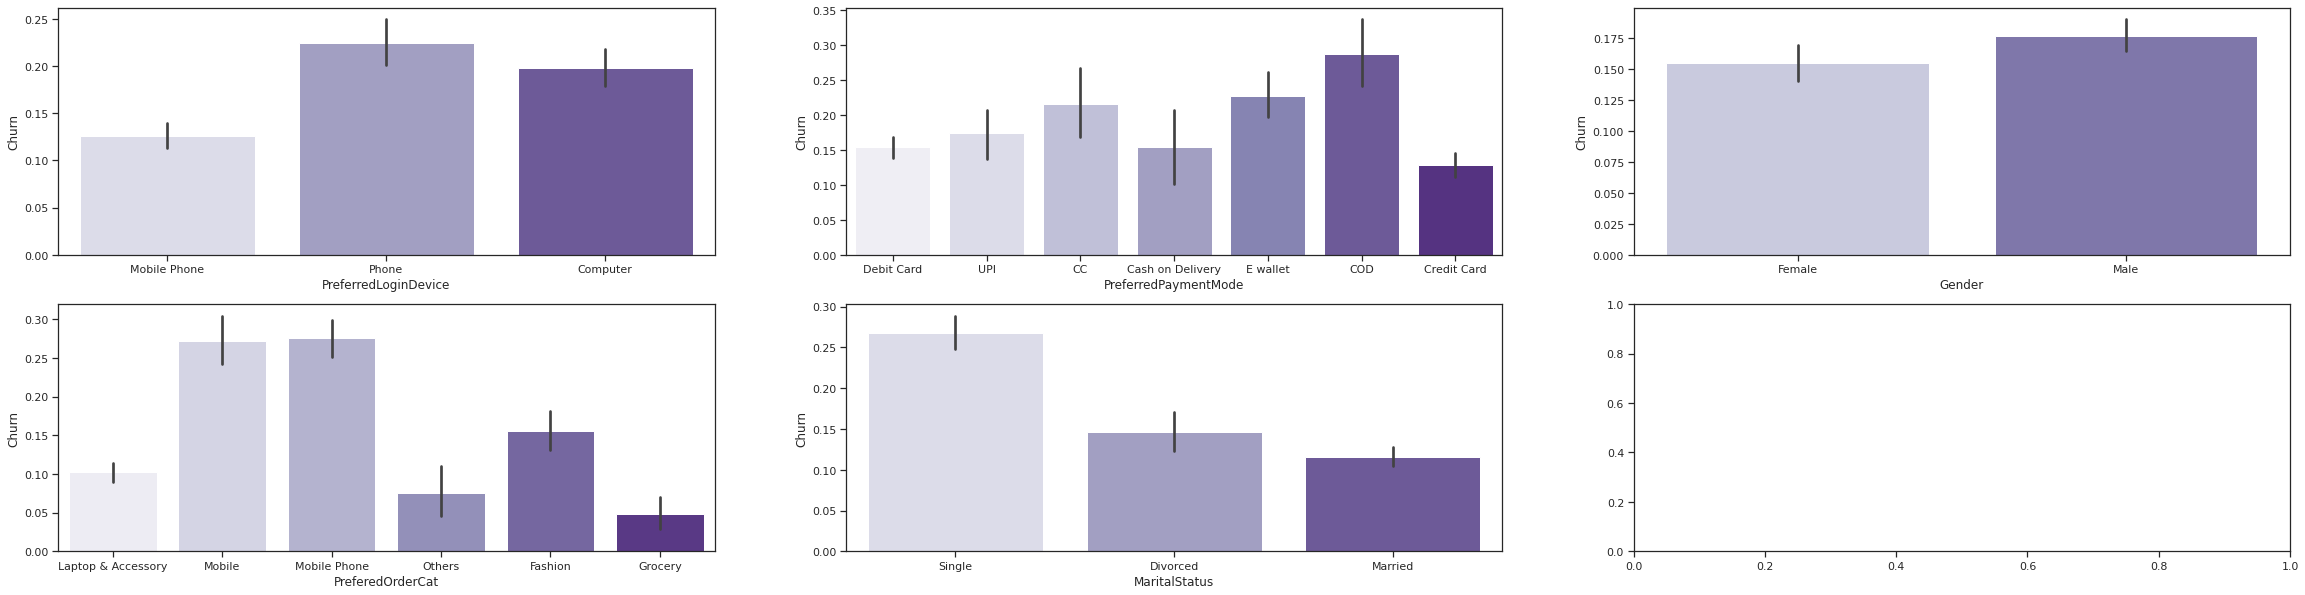

In [65]:
#grid of boxplots of the categorical variables vs price_range

fig, axes = plt.subplots(2, 3, figsize=(40,10))
axes = axes.flatten()

ax = sns.barplot(x ='PreferredLoginDevice', y ='Churn', data = df, palette = 'Purples', orient='v', ax=axes[0])
ax = sns.barplot(x ='PreferredPaymentMode', y ='Churn', data = df, palette = 'Purples', orient='v', ax=axes[1])
ax = sns.barplot(x ='Gender', y ='Churn', data = df, palette = 'Purples', orient='v', ax=axes[2])
ax = sns.barplot(x ='PreferedOrderCat', y ='Churn', data = df, palette = 'Purples', orient='v', ax=axes[3])
ax = sns.barplot(x ='MaritalStatus', y ='Churn', data = df, palette = 'Purples', orient='v', ax=axes[4])



### Data Cleaning

**INFORMATION LEAKAGE**

Should we consider this? Perhaps 'Satisfaction Score' could be leaking information?

# 2 - DATA PREPARATION

### Categorical Encoding

One-Hot encoding the categorical variables

In [241]:
df.columns

Index(['Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [242]:
df = pd.get_dummies(df, columns=['PreferredLoginDevice','CityTier', 'PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus','Complain'])

In [243]:
df.head()

,Churn,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,CityTier_1,CityTier_2,CityTier_3,PreferredPaymentMode_CC,PreferredPaymentMode_COD,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Complain_0,Complain_1
0,1,4.0,6.0,3.0,3,2,9,11.0,1.0,1.0,5.0,160,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
1,1,NaN,8.0,3.0,4,3,7,15.0,0.0,1.0,0.0,121,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1
2,1,NaN,30.0,2.0,4,3,6,14.0,0.0,1.0,3.0,120,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
3,1,0.0,15.0,2.0,4,5,8,23.0,0.0,1.0,3.0,134,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0
4,1,0.0,12.0,NaN,3,5,3,11.0,1.0,1.0,3.0,130,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0


In [244]:
df.dtypes

Churn                                      int64
Tenure                                   float64
WarehouseToHome                          float64
HourSpendOnApp                           float64
NumberOfDeviceRegistered                   int64
SatisfactionScore                          int64
NumberOfAddress                            int64
OrderAmountHikeFromlastYear              float64
CouponUsed                               float64
OrderCount                               float64
DaySinceLastOrder                        float64
CashbackAmount                             int64
PreferredLoginDevice_Computer              uint8
PreferredLoginDevice_Mobile Phone          uint8
PreferredLoginDevice_Phone                 uint8
CityTier_1                                 uint8
CityTier_2                                 uint8
CityTier_3                                 uint8
PreferredPaymentMode_CC                    uint8
PreferredPaymentMode_COD                   uint8
PreferredPaymentMode

In [245]:
#clean column names

def clean_col(name):
    return (
        name.strip().replace(" ", "")
    )

df = df.rename(columns=clean_col)
df.head()

,Churn,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_MobilePhone,PreferredLoginDevice_Phone,CityTier_1,CityTier_2,CityTier_3,PreferredPaymentMode_CC,PreferredPaymentMode_COD,PreferredPaymentMode_CashonDelivery,PreferredPaymentMode_CreditCard,PreferredPaymentMode_DebitCard,PreferredPaymentMode_Ewallet,PreferredPaymentMode_UPI,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop&Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_MobilePhone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Complain_0,Complain_1
0,1,4.0,6.0,3.0,3,2,9,11.0,1.0,1.0,5.0,160,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
1,1,NaN,8.0,3.0,4,3,7,15.0,0.0,1.0,0.0,121,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1
2,1,NaN,30.0,2.0,4,3,6,14.0,0.0,1.0,3.0,120,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
3,1,0.0,15.0,2.0,4,5,8,23.0,0.0,1.0,3.0,134,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0
4,1,0.0,12.0,NaN,3,5,3,11.0,1.0,1.0,3.0,130,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0


We will split the data into Train, Test and Validation sets, so that when we pre-process we do not leak information to the test and validation sets

### Correlations

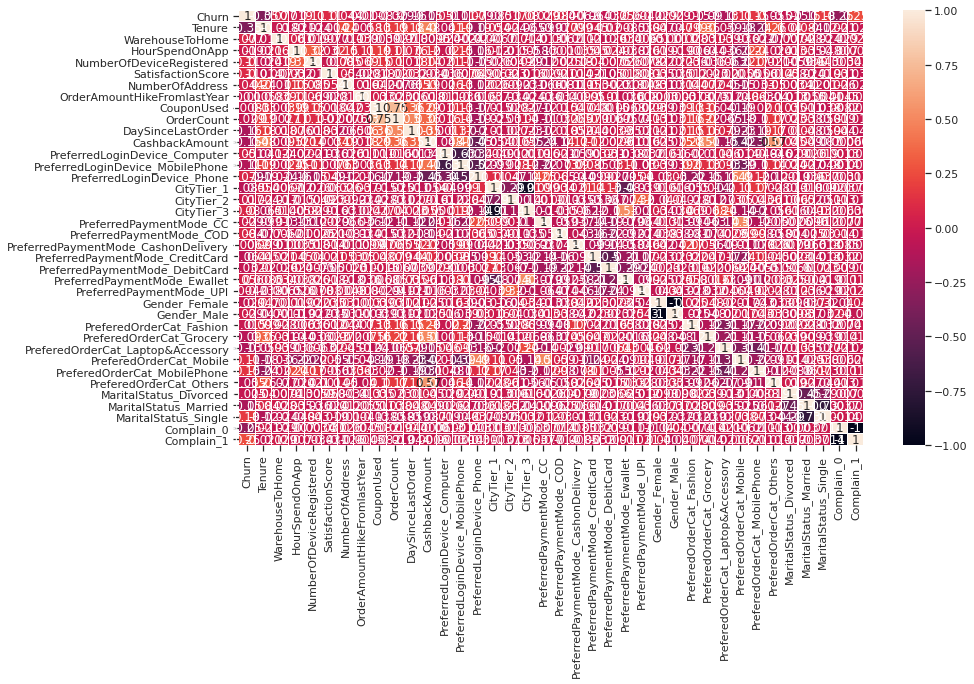

In [207]:
import seaborn as sns

plt.figure(figsize=(14,8))
sns.heatmap(df.corr(),annot = True,  linewidths=.05) #could add  cmap="Purples" to change the colors 
plt.show()

No correlation above 0.8. 

### TRAIN-TEST-VAL Split

In [285]:
X, y = jn.ml.get_features_targets(df, target_columns="Churn")

train(70%) , test(30%) split

In [286]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=42)

test(50%) val(50%) split

In [287]:
from sklearn.model_selection import train_test_split

test, val = train_test_split(test, test_size=0.5, random_state=42)

In [288]:
print(len(train))
print(len(test))
print(len(val))

3941
844
845


### Fill in Missing Values


In [289]:
train.head()

,Churn,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_MobilePhone,PreferredLoginDevice_Phone,CityTier_1,CityTier_2,CityTier_3,PreferredPaymentMode_CC,PreferredPaymentMode_COD,PreferredPaymentMode_CashonDelivery,PreferredPaymentMode_CreditCard,PreferredPaymentMode_DebitCard,PreferredPaymentMode_Ewallet,PreferredPaymentMode_UPI,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop&Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_MobilePhone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Complain_0,Complain_1
1559,1,0.0,NaN,2.0,3,5,6,11.0,0.0,1.0,4.0,127,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1
993,0,NaN,9.0,2.0,3,1,2,21.0,1.0,1.0,0.0,121,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
1187,1,0.0,24.0,NaN,1,5,1,17.0,1.0,1.0,0.0,130,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0
188,0,6.0,11.0,3.0,3,4,7,11.0,2.0,8.0,NaN,219,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0
4630,0,1.0,31.0,3.0,4,1,2,14.0,2.0,3.0,2.0,149,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0


In [290]:
train['DaySinceLastOrder'] = train['DaySinceLastOrder'].fillna(train['DaySinceLastOrder'].median())
train['OrderAmountHikeFromlastYear'] = train['OrderAmountHikeFromlastYear'].fillna(train['OrderAmountHikeFromlastYear'].median())
train['Tenure'] = train['Tenure'].fillna(train['Tenure'].median())
train['OrderCount'] = train['OrderCount'].fillna(train['OrderCount'].median())
train['CouponUsed'] = train['CouponUsed'].fillna(train['CouponUsed'].median())
train['HourSpendOnApp'] = train['HourSpendOnApp'].fillna(train['HourSpendOnApp'].median())
train['WarehouseToHome'] = train['WarehouseToHome'].fillna(train['WarehouseToHome'].median())

test['DaySinceLastOrder'] = test['DaySinceLastOrder'].fillna(test['DaySinceLastOrder'].median())
test['OrderAmountHikeFromlastYear'] = test['OrderAmountHikeFromlastYear'].fillna(test['OrderAmountHikeFromlastYear'].median())
test['Tenure'] = test['Tenure'].fillna(test['Tenure'].median())
test['OrderCount'] = test['OrderCount'].fillna(test['OrderCount'].median())
test['CouponUsed'] = test['CouponUsed'].fillna(test['CouponUsed'].median())
test['HourSpendOnApp'] = test['HourSpendOnApp'].fillna(test['HourSpendOnApp'].median())
test['WarehouseToHome'] = test['WarehouseToHome'].fillna(test['WarehouseToHome'].median())

val['DaySinceLastOrder'] = val['DaySinceLastOrder'].fillna(val['DaySinceLastOrder'].median())
val['OrderAmountHikeFromlastYear'] = val['OrderAmountHikeFromlastYear'].fillna(val['OrderAmountHikeFromlastYear'].median())
val['Tenure'] = val['Tenure'].fillna(val['Tenure'].median())
val['OrderCount'] = val['OrderCount'].fillna(val['OrderCount'].median())
val['CouponUsed'] = val['CouponUsed'].fillna(val['CouponUsed'].median())
val['HourSpendOnApp'] = val['HourSpendOnApp'].fillna(val['HourSpendOnApp'].median())
val['WarehouseToHome'] = val['WarehouseToHome'].fillna(val['WarehouseToHome'].median())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [291]:
# Re-check for missing values
miss_values_train = missing_values(train)
miss_values_test = missing_values(train)
miss_values_val = missing_values(train)

print(miss_values_train)
print(miss_values_test)
print(miss_values_val)

Dataframe has 38 columns.
There are 0 columns that have missing values.
Dataframe has 38 columns.
There are 0 columns that have missing values.
Dataframe has 38 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


### Outlier Treatment

Find outliers on the train set

Text(0, 0.5, 'Values')

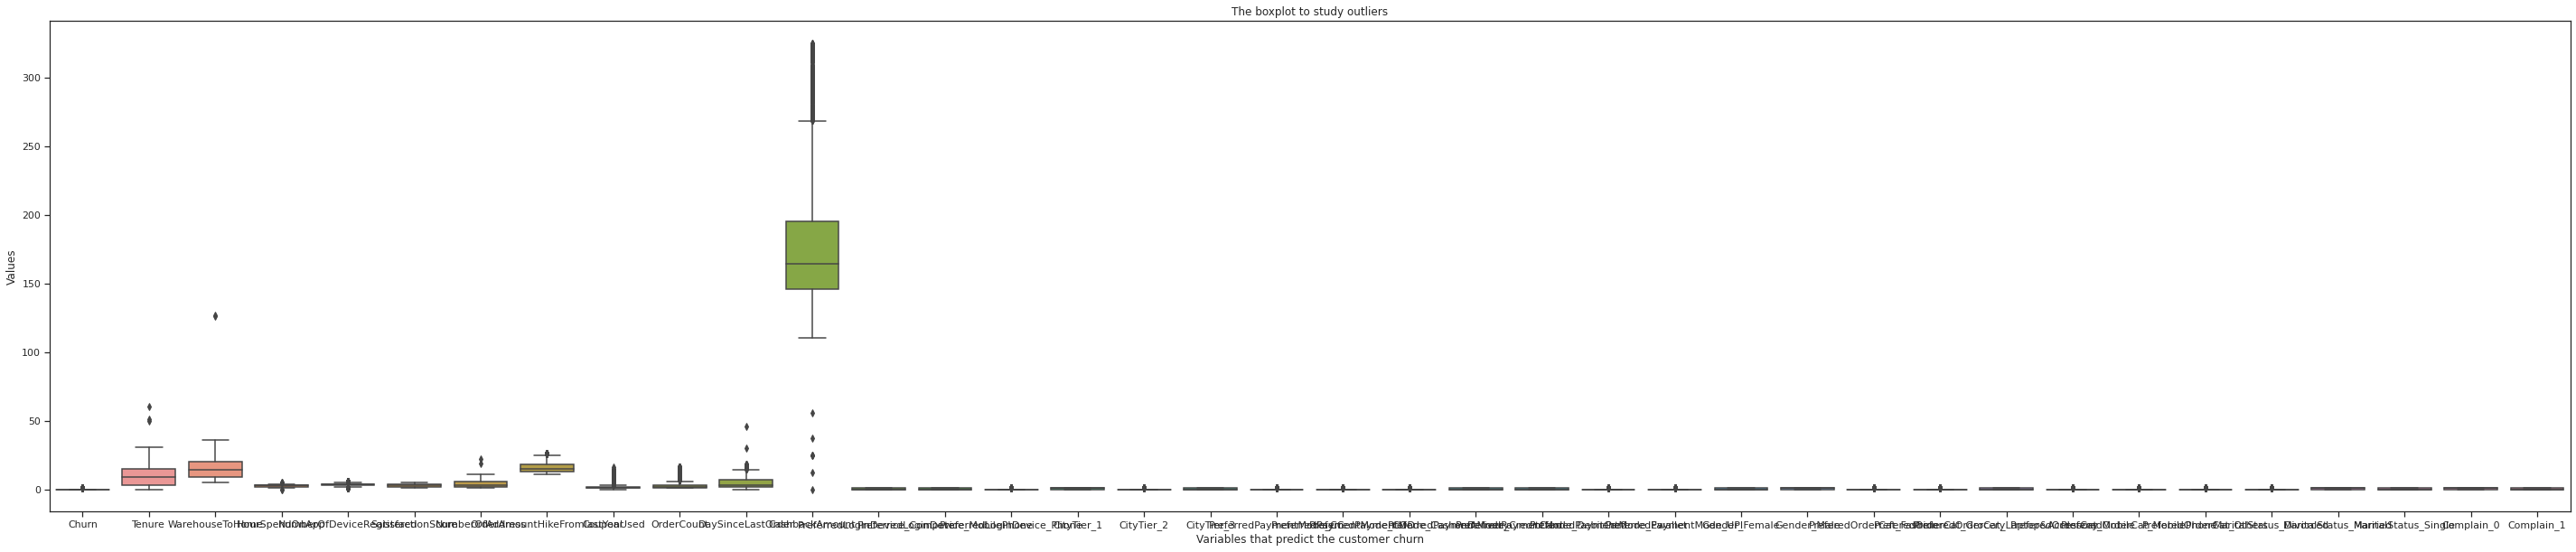

In [251]:
plt.figure(figsize=(50,10))
sns.boxplot(data=train)
plt.title('The boxplot to study outliers')
plt.xlabel('Variables that predict the customer churn')
plt.ylabel('Values')

Quite a lot of outliers, espcially with 'CashbackAmount'

In [292]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=100, random_state=42, contamination=0.02)
pred = iforest.fit_predict(train)
score = iforest.decision_function(train)

from numpy import where
anom_index = where(pred== -1)
values = train.iloc[anom_index]
values

,Churn,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_MobilePhone,PreferredLoginDevice_Phone,CityTier_1,CityTier_2,CityTier_3,PreferredPaymentMode_CC,PreferredPaymentMode_COD,PreferredPaymentMode_CashonDelivery,PreferredPaymentMode_CreditCard,PreferredPaymentMode_DebitCard,PreferredPaymentMode_Ewallet,PreferredPaymentMode_UPI,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop&Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_MobilePhone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Complain_0,Complain_1
627,1,0.0,22.0,3.0,1,5,2,16.0,15.0,15.0,14.0,127,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0
869,0,25.0,34.0,2.0,1,3,3,11.0,0.0,2.0,2.0,232,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3442,1,1.0,23.0,3.0,2,5,3,17.0,16.0,16.0,15.0,152,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0
4600,1,1.0,30.0,3.0,4,5,11,16.0,2.0,2.0,3.0,225,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1
328,1,0.0,23.0,3.0,3,3,1,11.0,0.0,1.0,0.0,127,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,0,6.0,15.0,4.0,5,4,3,12.0,7.0,12.0,10.0,177,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3987,1,1.0,27.0,4.0,4,4,2,12.0,1.0,2.0,5.0,146,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
3234,0,21.0,10.0,3.0,4,3,11,13.0,1.0,12.0,14.0,263,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1
3748,1,1.0,31.0,3.0,5,4,2,24.0,3.0,11.0,11.0,171,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1


Out of 3941 observations, there are 79 outliers. **We will remove the outliers**

In [293]:
train = train[~train.index.isin(values.index)]
train.shape

(3862, 38)

### Separate Features and Targets

Separate in train, test and val sets

In [310]:
y_train = train['Churn']
X_train = train.drop(columns=['Churn'])

y_test = test['Churn']
X_test = test.drop(columns=['Churn'])

y_val = val['Churn']
X_val = val.drop(columns=['Churn'])

In [295]:
X_train.columns

Index(['Tenure', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount', 'PreferredLoginDevice_Computer',
       'PreferredLoginDevice_MobilePhone', 'PreferredLoginDevice_Phone',
       'CityTier_1', 'CityTier_2', 'CityTier_3', 'PreferredPaymentMode_CC',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_CashonDelivery',
       'PreferredPaymentMode_CreditCard', 'PreferredPaymentMode_DebitCard',
       'PreferredPaymentMode_Ewallet', 'PreferredPaymentMode_UPI',
       'Gender_Female', 'Gender_Male', 'PreferedOrderCat_Fashion',
       'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop&Accessory',
       'PreferedOrderCat_Mobile', 'PreferedOrderCat_MobilePhone',
       'PreferedOrderCat_Others', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single', 'Complain_0',
       'Complain_1'],
   

### Baseline Model Classifier

In [296]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='warn')

Accuracy

In [297]:
dummy_clf.score(X_val, y_val)

0.7408284023668639

Precision

In [298]:
print(metrics.confusion_matrix(y_val, dummy_clf.predict(X_val)))

[[590 125]
 [112  18]]


In [301]:
print(metrics.classification_report(dummy_clf.predict(X_val), y_val, digits=3))

              precision    recall  f1-score   support

           0      0.838     0.842     0.840       711
           1      0.138     0.134     0.136       134

    accuracy                          0.730       845
   macro avg      0.488     0.488     0.488       845
weighted avg      0.727     0.730     0.729       845



### Standardize the Data

In [302]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

### Evaluation Metrics

ROC Curves

In [344]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

PR Curve

In [345]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

Classification Score

In [346]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

Classification Metrics

In [347]:
def evaluation_metrics(y_actual, y_pred):
            
        precision, recall, _ = precision_recall_curve(y_actual, y_pred)
        average_precision = average_precision_score(y_actual, y_pred)
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_actual, y_pred)
        roc_auc = roc_auc_score(y_actual, y_pred)
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_actual, y_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_actual, y_pred)))

### Dealing with Imbalanced Data

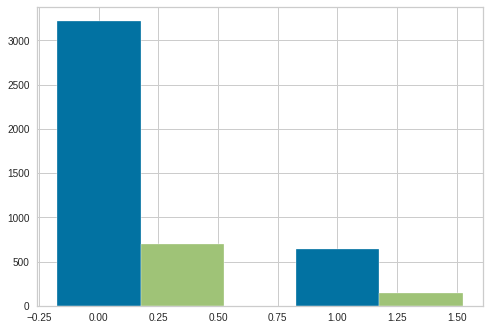

In [308]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=[0, 1])

visualizer.fit(y_train, y_test)        # Fit the data to the visualizer
visualizer.draw()  

The resulting figure allows us to diagnose the severity of the balance issue. In this figure we can see that the "0" class dominates the "1" class. 

In [312]:
print('Before OverSampling, the shape of X: {}'.format(X_train.shape)) 
print('Before OverSampling, the shape of y: {} \n'.format(y_train.shape)) 
  
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, the shape of X: (3862, 37)
Before OverSampling, the shape of y: (3862,) 

Before OverSampling, counts of label '1': 644
Before OverSampling, counts of label '0': 3218


Oversampling

In [372]:
from imblearn.over_sampling import (
    RandomOverSampler,
)
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)
pd.Series(y_train_ros).value_counts()

1    3218
0    3218
dtype: int64

In [338]:
print('After OverSampling, the shape of X: {}'.format(X_ros.shape)) 
print('After OverSampling, the shape of y: {} \n'.format(y_ros.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_ros == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_ros == 0)))

After OverSampling, the shape of X: (6436, 37)
After OverSampling, the shape of y: (6436,) 

After OverSampling, counts of label '1': 3218
After OverSampling, counts of label '0': 3218


In [337]:
X_train_ros

array([[ 0., 14.,  2., ...,  1.,  0.,  1.],
       [ 9.,  9.,  2., ...,  0.,  1.,  0.],
       [ 0., 24.,  3., ...,  0.,  1.,  0.],
       ...,
       [ 1., 16.,  3., ...,  1.,  1.,  0.],
       [ 1., 19.,  3., ...,  1.,  1.,  0.],
       [ 0., 11.,  2., ...,  1.,  0.,  1.]])

ANOTHER METHOD: SMOTE

In [371]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
pd.Series(y_train_sm).value_counts()

1    3218
0    3218
dtype: int64

Turning array into a dataframe

In [374]:
cols = list(X_train.columns)
X_train_ros=pd.DataFrame(X_train_ros)
X_train_ros.columns=cols
#Renaming column name of Target variable
y_train_ros=pd.DataFrame(y_train_ros)
y_train_ros.columns = ['Churn_1']
scaled_train_df = pd.concat([X_train_ros,y_train_ros], axis=1)
scaled_train_df

,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Computer,PreferredLoginDevice_MobilePhone,PreferredLoginDevice_Phone,CityTier_1,CityTier_2,CityTier_3,PreferredPaymentMode_CC,PreferredPaymentMode_COD,PreferredPaymentMode_CashonDelivery,PreferredPaymentMode_CreditCard,PreferredPaymentMode_DebitCard,PreferredPaymentMode_Ewallet,PreferredPaymentMode_UPI,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop&Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_MobilePhone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Complain_0,Complain_1,Churn_1
0,0.0,14.0,2.0,3.0,5.0,6.0,11.0,0.0,1.0,4.0,127.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
1,9.0,9.0,2.0,3.0,1.0,2.0,21.0,1.0,1.0,0.0,121.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
2,0.0,24.0,3.0,1.0,5.0,1.0,17.0,1.0,1.0,0.0,130.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
3,6.0,11.0,3.0,3.0,4.0,7.0,11.0,2.0,8.0,3.0,219.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,1.0,31.0,3.0,4.0,1.0,2.0,14.0,2.0,3.0,2.0,149.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6431,9.0,7.0,2.0,3.0,4.0,2.0,11.0,2.0,2.0,2.0,123.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
6432,1.0,7.0,3.0,4.0,4.0,3.0,12.0,2.0,3.0,3.0,148.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1
6433,1.0,16.0,3.0,4.0,5.0,9.0,23.0,2.0,2.0,5.0,167.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1
6434,1.0,19.0,3.0,2.0,4.0,3.0,16.0,1.0,2.0,1.0,152.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1


# 3 - MODELLING



### Dummy Classifier

In [375]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier()
clf_dummy.fit(X_train_ros, y_train_ros)

DummyClassifier(constant=None, random_state=None, strategy='warn')

Validation Result:

accuracy score: 0.4727



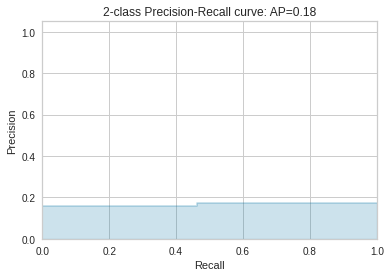

roc auc score: 0.4810616151151892



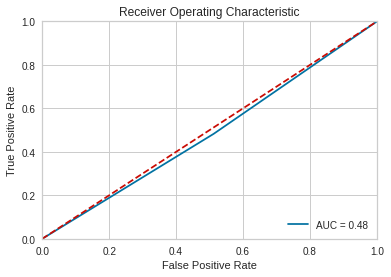

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.47      0.60       699
           1       0.17      0.52      0.26       145

    accuracy                           0.48       844
   macro avg       0.50      0.50      0.43       844
weighted avg       0.71      0.48      0.54       844


Confusion Matrix: 
 [[352 347]
 [ 80  65]]

End of validation Result



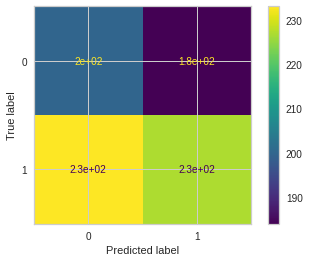

In [376]:
clf_score(clf_dummy, X_train_ros, y_train_ros, X_test, y_test, train=False)

### Logistic Regression

In [377]:
from sklearn.linear_model import LogisticRegression

clf_log_reg = LogisticRegression(C=0.0001, random_state=42, max_iter=1000)
clf_log_reg.fit(X_train_ros, y_train_ros)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Validation Result:

accuracy score: 0.7050



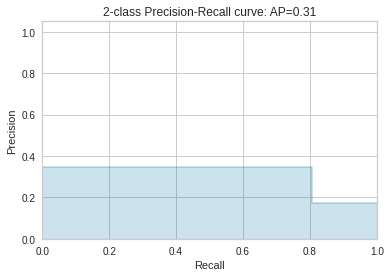

roc auc score: 0.7453653001825267



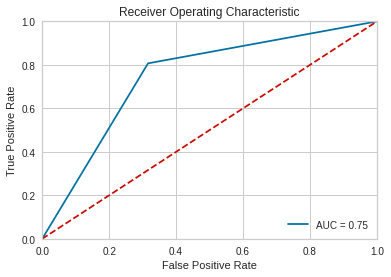

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.68      0.79       699
           1       0.35      0.81      0.48       145

    accuracy                           0.70       844
   macro avg       0.65      0.75      0.64       844
weighted avg       0.84      0.70      0.74       844


Confusion Matrix: 
 [[478 221]
 [ 28 117]]

End of validation Result



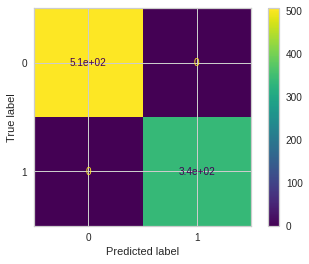

In [378]:
clf_score(clf_log_reg, X_train_ros, y_train_ros, X_test, y_test, train=False)

### Random Forest

In [379]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=40, random_state=42)
clf_rf.fit(X_train_ros, y_train_ros)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Validation Result:

accuracy score: 0.9668



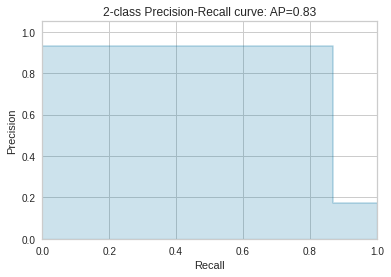

roc auc score: 0.9280449903803463



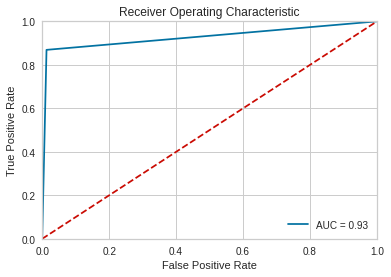

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       699
           1       0.93      0.87      0.90       145

    accuracy                           0.97       844
   macro avg       0.95      0.93      0.94       844
weighted avg       0.97      0.97      0.97       844


Confusion Matrix: 
 [[690   9]
 [ 19 126]]

End of validation Result



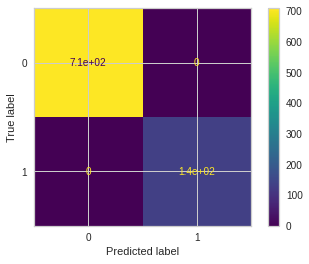

In [421]:
clf_score(clf_rf, X_train_ros, y_train_ros, X_test, y_test, train=False)

### KNN

In [381]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn=RandomForestClassifier(n_estimators=40, random_state=42)
clf_knn.fit(X_train_ros, y_train_ros)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Validation Result:

accuracy score: 0.9668



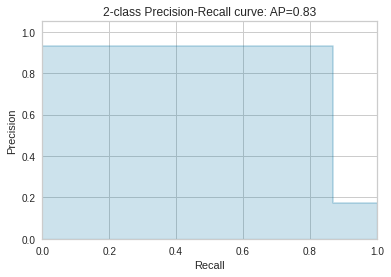

roc auc score: 0.9280449903803463



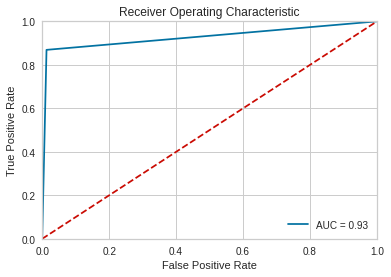

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       699
           1       0.93      0.87      0.90       145

    accuracy                           0.97       844
   macro avg       0.95      0.93      0.94       844
weighted avg       0.97      0.97      0.97       844


Confusion Matrix: 
 [[690   9]
 [ 19 126]]

End of validation Result



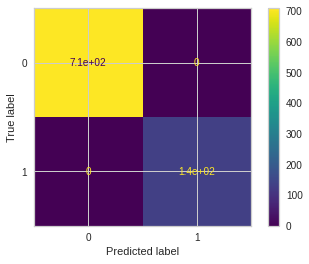

In [382]:
clf_score(clf_knn, X_train_ros, y_train_ros, X_test, y_test, train=False)

### XGBoost

In [383]:
import xgboost as xgb

clf_xgb=xgb.XGBClassifier(random_state=1, learning_rate=0.01)
clf_xgb.fit(X_train_ros, y_train_ros)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Validation Result:

accuracy score: 0.8472



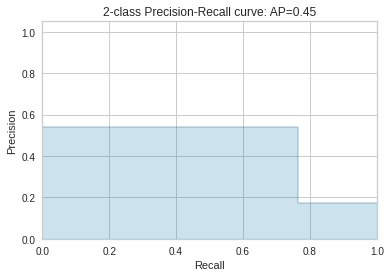

roc auc score: 0.8148044003749199



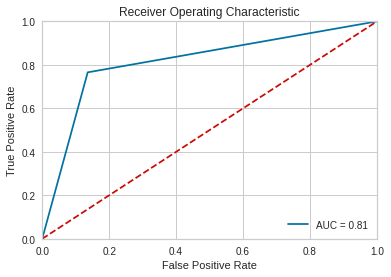

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.86      0.90       699
           1       0.54      0.77      0.63       145

    accuracy                           0.85       844
   macro avg       0.74      0.81      0.77       844
weighted avg       0.88      0.85      0.86       844


Confusion Matrix: 
 [[604  95]
 [ 34 111]]

End of validation Result



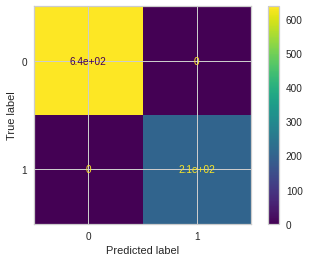

In [384]:
clf_score(clf_xgb, X_train_ros, y_train_ros, X_test, y_test, train=False)

### AdaBoost

In [386]:
from sklearn.ensemble import AdaBoostClassifier

clf_ada_boost = AdaBoostClassifier(n_estimators=40, random_state=42)
clf_ada_boost.fit(X_train_ros, y_train_ros)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=40, random_state=42)

Validation Result:

accuracy score: 0.8377



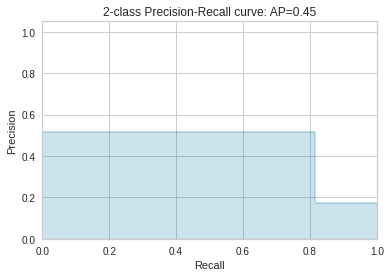

roc auc score: 0.8282127176754969



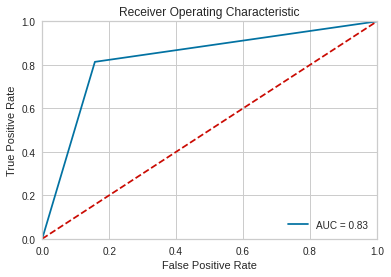

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.84      0.90       699
           1       0.52      0.81      0.63       145

    accuracy                           0.84       844
   macro avg       0.74      0.83      0.76       844
weighted avg       0.88      0.84      0.85       844


Confusion Matrix: 
 [[589 110]
 [ 27 118]]

End of validation Result



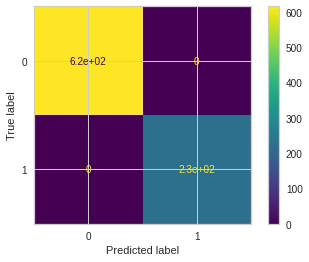

In [390]:
clf_score(clf_ada_boost, X_train_ros, y_train_ros, X_test, y_test, train=False)

### CatBoost

In [388]:
!pip install catboost

     |████████████████████████████████| 65.8MB 61kB/s 


In [389]:
from catboost import CatBoostClassifier, Pool

cls_cat_boost = CatBoostClassifier(iterations=2,
                                   depth=2,
                                   learning_rate=1,
                                   loss_function='Logloss',
                                   verbose=True)
# train the model
cls_cat_boost.fit(X_train_ros, y_train_ros)

0:	learn: 0.5019535	total: 51.3ms	remaining: 51.3ms
1:	learn: 0.4573223	total: 54.2ms	remaining: 0us


In [391]:
# make the prediction using the resulting model
preds_class = cls_cat_boost.predict(X_test)
preds_proba = cls_cat_boost.predict_proba(X_test)
print("class = ", preds_class)
print("proba = ", preds_proba)

class =  [1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1
 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1
 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0
 0 0 1 0 0 0 0 0

Validation Result:

accuracy score: 0.8246



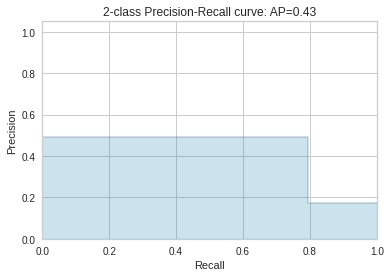

roc auc score: 0.8121454294312072



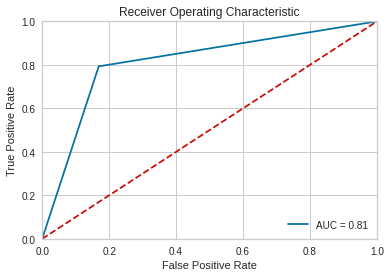

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.83      0.89       699
           1       0.49      0.79      0.61       145

    accuracy                           0.82       844
   macro avg       0.72      0.81      0.75       844
weighted avg       0.87      0.82      0.84       844


Confusion Matrix: 
 [[581 118]
 [ 30 115]]

End of validation Result



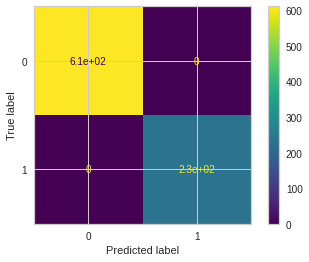

In [392]:
clf_score(cls_cat_boost, X_train_ros, y_train_ros, X_test, y_test, train=False)

### AutoKeras

In [393]:
! pip install autokeras==1.0.0b0

     |████████████████████████████████| 51kB 3.0MB/s 
     |████████████████████████████████| 71kB 3.6MB/s 
  Created wheel for autokeras: filename=autokeras-1.0.0b0-cp36-none-any.whl size=48700 sha256=9c92f6513c114dd25afd6b04d2de3443e2dc7ece0bca9cf4ea3e1fff7ff4c6b3
  Stored in directory: /root/.cache/pip/wheels/cb/57/40/5ada57a9b2515e584c130b050d289c57481e5ea19a0c6196a2
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=9eb94503916129dac65a59b72811390e597e4ee8288db1406bc1a3f5b4c3ac5a
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=b24df51a603b0d4cb2de67cef4cd580a91eac8190e15eeed2da5748aeafdad45
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built autokeras keras-tuner terminaltables


In [422]:
import autokeras as ak

# It tries 10 different models.
clf_auto_keras = ak.StructuredDataClassifier(max_trials=10)
# Feed the structured data classifier with training data.
clf_auto_keras.fit(X_train, y_train)
# Predict with the best model.
predicted_y = clf_auto_keras.predict(X_test)
# Evaluate the best model with testing data.
print(clf_auto_keras.evaluate(X_test, y_test))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
structured_data...|dense             |?                 
light_gbm_1/lig...|5                 |?                 
light_gbm_1/lig...|0.6               |?                 
light_gbm_1/lig...|10                |?                 
light_gbm_1/lig...|0.105             |?                 
light_gbm_1/lig...|50                |?                 
optimizer         |adam              |?                 

Epoch 1/1000


AttributeError: ignored

Try different classifiers

DecisionTreeClassifier
Validation Result:

accuracy score: 0.9277



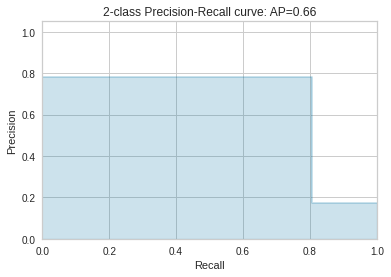

roc auc score: 0.8798431256474768



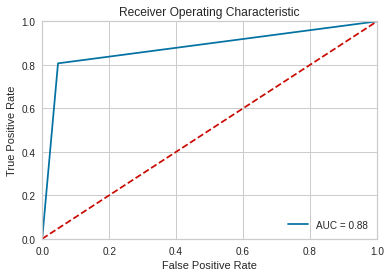

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       699
           1       0.78      0.81      0.79       145

    accuracy                           0.93       844
   macro avg       0.87      0.88      0.87       844
weighted avg       0.93      0.93      0.93       844


Confusion Matrix: 
 [[666  33]
 [ 28 117]]

End of validation Result

GaussianNB            
Validation Result:

accuracy score: 0.6043



/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


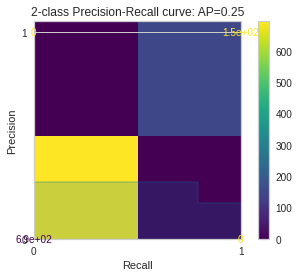

roc auc score: 0.679098219130778



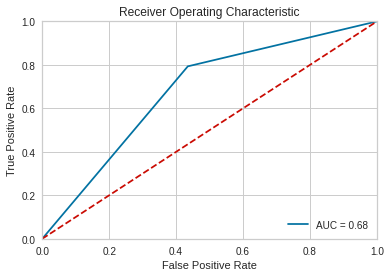

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.57      0.70       699
           1       0.27      0.79      0.41       145

    accuracy                           0.60       844
   macro avg       0.60      0.68      0.56       844
weighted avg       0.82      0.60      0.65       844


Confusion Matrix: 
 [[395 304]
 [ 30 115]]

End of validation Result



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC                   
Validation Result:

accuracy score: 0.7156



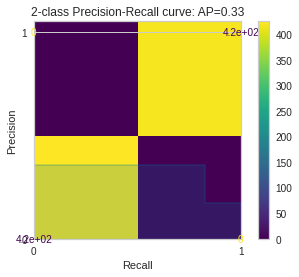

roc auc score: 0.7600019732622958



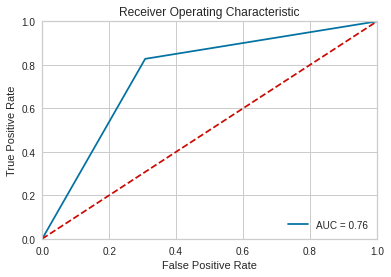

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.69      0.80       699
           1       0.36      0.83      0.50       145

    accuracy                           0.72       844
   macro avg       0.65      0.76      0.65       844
weighted avg       0.85      0.72      0.75       844


Confusion Matrix: 
 [[484 215]
 [ 25 120]]

End of validation Result

KNeighborsClassifier  
Validation Result:

accuracy score: 0.8246



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]


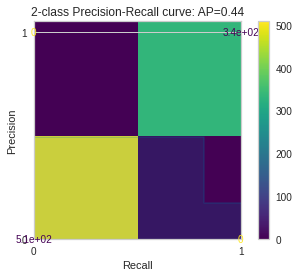

roc auc score: 0.8230773025504414



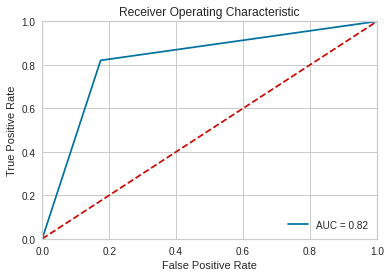

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       699
           1       0.49      0.82      0.62       145

    accuracy                           0.82       844
   macro avg       0.73      0.82      0.75       844
weighted avg       0.88      0.82      0.84       844


Confusion Matrix: 
 [[577 122]
 [ 26 119]]

End of validation Result



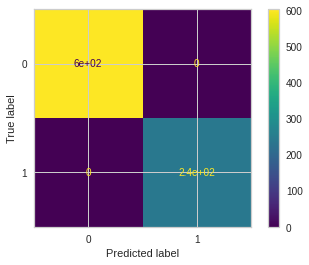

In [408]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

for model in [
    DecisionTreeClassifier,
    GaussianNB,
    SVC,
    KNeighborsClassifier,
]:
    clf = model()
    clf.fit(X_train_ros, y_train_ros)
    print(f"{model.__name__:22}")
    clf_score(clf, X_train_ros, y_train_ros, X_test, y_test, train=False)


In [411]:
for model in [
        DummyClassifier,
        DecisionTreeClassifier,
        KNeighborsClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier,
        xgb.XGBClassifier,
]:
    cls = model()
    kfold = model_selection.KFold(n_splits=10, random_state=42)
    s = model_selection.cross_val_score(cls, X_train, y_train, scoring="roc_auc", cv=kfold)
    print(f"{model.__name__:22}  AUC: " f"{s.mean():.3f} STD: {s.std():.2f}")

DummyClassifier         AUC: 0.520 STD: 0.02
DecisionTreeClassifier  AUC: 0.882 STD: 0.02
KNeighborsClassifier    AUC: 0.840 STD: 0.02
GaussianNB              AUC: 0.795 STD: 0.04
SVC                     AUC: 0.885 STD: 0.03
RandomForestClassifier  AUC: 0.976 STD: 0.01
XGBClassifier           AUC: 0.933 STD: 0.01


# 4 - MODEL SELECTION AND TUNING

### Compare Models

In [ ]:
mse_comparison = {'Model':['Logistic Regression','Random Forest','KNN','XGBoost','AdaBoost','CatBoost','AutoKeras'],
                 'Accuracy': [lasso_mse,ridge_mse,mars_mse,tree_mse,knn_mse,rf_mse,gbt_mse,ann_mse],
                 'AUC-ROC': [lasso_r2,ridge_r2,mars_r2,tree_r2,knn_r2,rf_r2,gbt_r2,ann_r2]}


mse_comparison = pd.DataFrame(mse_comparison)
mse_comparison

plt.figure(figsize=(15,8))
sns.barplot(x="Model", y="MSE", data=mse_comparison, palette='Purples')

### Model Selection

The best performing model was 

In [427]:
roc_auc_score(y_test, clf_log_reg.decision_function(X_test))

0.8183908045977012